# Process MRZERO simulated QRAGE data
(C) 2025 Forschungszentrum Jülich

Author: Jörg Felder

In [1]:
import os
import sys

sys.path.insert(0, "../src")

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import ismrmrd
import torch
import h5py

import matplotlib.pyplot as plt
import numpy as np

from juart.preproc.data import KSpaceData
from juart.conopt.functional.fourier import fourier_transform_adjoint
from juart.preproc.trajectory import KSpaceTrajectory

torch.set_num_threads(1)

In [2]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'

In [3]:
# load ISMRMRD File
full_h5_ismrmrd_fname = os.path.join(filepath, 'LocalData', 'Simulations', 'qrage.h5')
dataset = ismrmrd.Dataset(
    full_h5_ismrmrd_fname,
    dataset_name="dataset",
    create_if_needed=False,
)

In [4]:
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'qrage_info.h5'), 'r') as f:
    num_spokes = f['num_spokes'][...]
    num_sets = f['num_sets'][...]
    num_echoes = f['num_echoes'][...]
    num_partitions_per_block = f['num_partitions_per_block'][...]
    num_autocalibration_lines = f['num_autocalibration_lines'][...]
    acceleration_factor = f['acceleration_factor'][...]
    matrix_size = f['matrix_size'][...]
    readout_bandwidth = f['readout_bandwidth'][...]

In [5]:
NCha = 1
NCol = matrix_size[1]
NLin = num_spokes
NPar = matrix_size[2]
NSli = 1
NSet = num_sets
NEco = num_echoes

NPar_post, NSli_post = NSli, NPar
NCha_comp, ISet_comp, IEco_comp = NCha, slice(NSet - 1, NSet), slice(0, 1)
NImx, NImy, ISet_coil, IEco_coil = 256, 256, slice(15, 19), slice(0, 1)

NAcl = num_autocalibration_lines
NUsf = acceleration_factor
NLin_retro = NLin

In [6]:
print(NCha, NCol, NLin, NPar, NSli, NSet, NEco)

1 128 64 8 1 9 3


In [7]:
# load kspace
kdata = KSpaceData((NCha, NCol, NLin, NPar, NSli, NSet, NEco))
kdata.read_data(dataset, is_pulseq=True)

/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2883) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/13824 [00:00<?, ?it/s]

In [8]:
# Undersample along line dimension
# Here we keep the data size unchaged as we did not oversample in the simulation
kdata.index_data([slice(None), slice(None), slice(NLin_retro), ...])

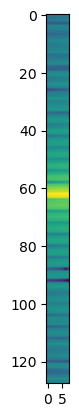

In [9]:
plt.figure()
plt.imshow(torch.log(torch.abs(kdata.kdata[0, :, 0, :, 0, 0, 0]) + 1e-16).numpy())

### Grappa

In [10]:
kdata.apply_mask(NUsf, NAcl, is_pulseq=True)
kdata.reconstruct_partitions()

  0%|          | 0/1728 [00:00<?, ?it/s]

### Coil compression

In [11]:
# Swap Par and Sli Partition
kdata.swapaxes(3, 4)

In [12]:
# comp_matrix = kdata.compression_matrix(NCha_comp, ISet_comp, IEco_comp)
# kdata.compress_data(comp_matrix)

In [13]:
# Swap Col and Lin dimension
kdata.swapaxes(1, 2)

In [14]:
NCha, NLin, NCol, NPar, NSli, NSet, NEco = kdata.kdata_shape

In [15]:
print(NCha, NCol, NLin, NPar, NSli, NSet, NEco)

1 128 64 1 8 9 3


In [16]:
print("(4/4) Creating output file ....")
full_h5_preproc_fname = os.path.join(filepath, 'LocalData', 'Simulations','qrage_grappa_pytorch.h5')

with h5py.File(full_h5_preproc_fname, "w", libver="latest") as out_file:
    out_file.create_dataset(
        "d", data=kdata.kdata.numpy(), chunks=(NCha, NLin, NCol, 1, 1, 1, 1)
    )

(4/4) Creating output file ....


In [27]:
print(kdata.kdata[0, 0, :, 0, :, 0, 0].T.numpy().shape)

(8, 128)


(np.float64(-0.5), np.float64(127.5), np.float64(7.5), np.float64(-0.5))

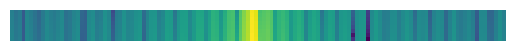

In [17]:
plt.imshow(
    torch.log(torch.abs(kdata.kdata[0, 0, :, 0, :, 0, 0].T)).numpy())
plt.axis("off")

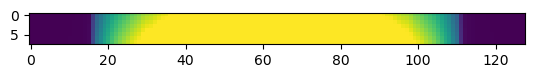

In [18]:
plt.figure()
plt.imshow(
    torch.abs(
        fourier_transform_adjoint(kdata.kdata[0, 0, :, 0, :, 0, 0], axes=(0,)).T
    ).numpy(),
    vmin=0,
    vmax=100,
)

In [19]:
print(kdata.kdata.shape)

torch.Size([1, 64, 128, 1, 8, 9, 3])


### Gradient delay correction - here obsolete

In [20]:
ktraj = KSpaceTrajectory(NLin, NCol, NSet, NEco)

In [21]:
with h5py.File(full_h5_preproc_fname, "r+", libver="latest") as h5_preproc_file:
    dset = h5_preproc_file.create_dataset(
        "k", data=ktraj.ktraj_nom.numpy(), chunks=(2, NLin_retro, NCol, 1, 1, 1, 1)
    )

### Coil Sensitivity Estimation (SAKE + ESPIRiT)

In [22]:
sensmaps = kdata.get_sensmaps(ktraj.ktraj_nom, (NCha, NImx, NImy, 1, NSli, 1, 1), multi_contrast=False)
# sensmaps = torch.ones((NCha, NImx, NImy, 1, NSli, 1, 1), dtype=torch.complex64)

  0%|          | 0/8 [00:00<?, ?it/s]

In [23]:
print(sensmaps.shape)

torch.Size([1, 256, 256, 1, 8, 1, 1])


In [24]:
with h5py.File(full_h5_preproc_fname, "r+", libver="latest") as h5_preproc_file:
    dset = h5_preproc_file.create_dataset(
        "C",
        data=sensmaps.numpy(),
        chunks=(NCha_comp, NImx, NImy, NPar_post, NSli_post, 1, 1),
    )

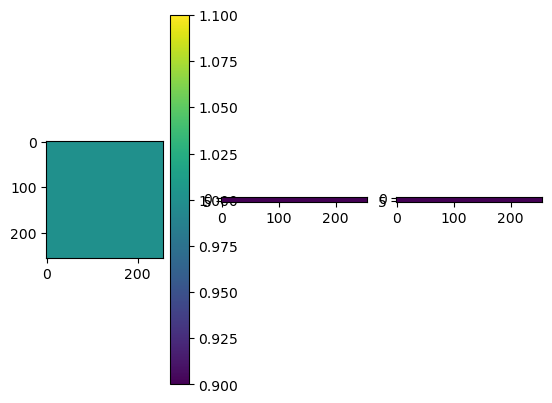

In [25]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(torch.abs(sensmaps[0, :, :, 0, matrix_size[2]//2, 0, 0]).numpy())
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(torch.abs(sensmaps[0, :, matrix_size[1]//2, 0, :, 0, 0]).T.numpy())
plt.subplot(1, 3, 3)
plt.imshow(torch.abs(sensmaps[0, matrix_size[0]//2, :, 0, :, 0, 0]).T.numpy())

In [26]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(torch.abs(sensmaps[0, :, matrix_size[1]//2, 0, :, 0, 0].T).numpy(), vmin=0, vmax=1)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(torch.abs(sensmaps[-1, :, matrix_size[1]//2, 0, :, 0, 0].T).numpy(), vmin=0, vmax=1)
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(7.5), np.float64(-0.5))